In [1]:
import perfplot
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import os

import numpy as np

# Protobuf
import numpymessage_pb2

# Avro
import avro.schema
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter

# JSON
import json

### Protobuf

In [2]:
def protobuf_round(array: np.ndarray) -> np.ndarray:
    message = numpymessage_pb2.NumPyMessage()
    message.array = array.tobytes()
    message.dtype = np.lib.format.dtype_to_descr(array.dtype)
    serialized = message.SerializeToString()

    deserialized = numpymessage_pb2.NumPyMessage()
    deserialized.ParseFromString(serialized)
    dtype = np.lib.format.descr_to_dtype(deserialized.dtype)
    return np.frombuffer(deserialized.array, dtype=dtype)

def protobuf_size(array: np.ndarray) -> int:
    message = numpymessage_pb2.NumPyMessage()
    message.array = array.tobytes()
    message.dtype = np.lib.format.dtype_to_descr(array.dtype)
    serialized = message.SerializeToString()
    return sys.getsizeof(serialized)

### Avro

In [3]:
schema = avro.schema.parse(open("numpy.avsc", "rb").read())

def avro_round(array: np.ndarray) -> np.ndarray:
    # TODO: Can we serialize in-memory without writing to a file?
    with DataFileWriter(open("numpy.avro", "wb"), DatumWriter(), schema) as writer:
        writer.append({"dtype": np.lib.format.dtype_to_descr(array.dtype), "array": array.tobytes()})

    with DataFileReader(open("numpy.avro", "rb"), DatumReader()) as reader:
        deserialized = next(reader)
        dtype = np.lib.format.descr_to_dtype(deserialized["dtype"])
        return np.frombuffer(deserialized["array"], dtype=dtype)

def avro_size(array: np.ndarray) -> np.ndarray:
    with DataFileWriter(open("numpy.avro", "wb"), DatumWriter(), schema) as writer:
        writer.append({"dtype": np.lib.format.dtype_to_descr(array.dtype), "array": array.tobytes()})
    return sys.getsizeof("numpy.avro")

### `npy`

In [4]:
def npy_round(array: np.ndarray) -> np.ndarray:
    np.save("temp.npy", array)
    return np.load("temp.npy")

def npy_size(array: np.ndarray) -> int:
    np.save("temp.npy", array)
    return os.stat("temp.npy").st_size

## (UCAP) Cast to Python `float` + JSON

In [5]:
def json_round(array: np.ndarray) -> np.ndarray:
    # Assumption: 1D
    python_value = [float(value) for value in array]
    serialized = json.dumps({"array": python_value})

    # Not NumPy
    return json.loads(serialized)["array"]

def json_size(array: np.ndarray) -> np.ndarray:
    # Assumption: 1D
    python_value = [float(value) for value in array]
    serialized = json.dumps({"array": python_value})
    return sys.getsizeof(serialized)

## Serialization/deserialization performance

Output()

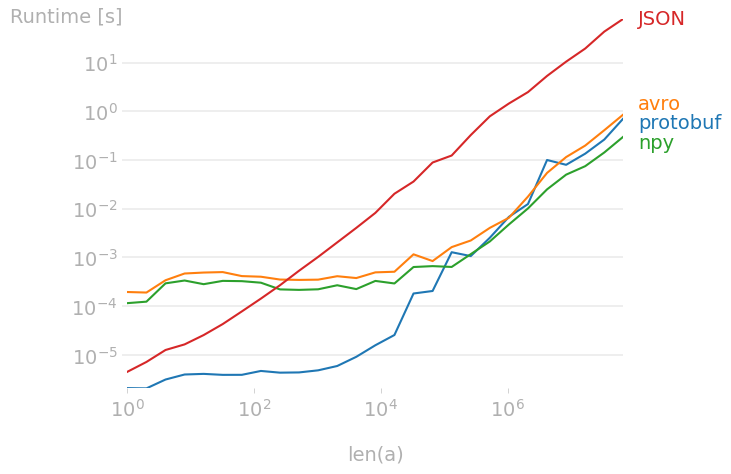

In [6]:
perfplot.show(
    setup=lambda n: np.random.rand(n),
    kernels=[
        protobuf_round,
        avro_round,
        npy_round,
        json_round,
    ],
    labels=["protobuf", "avro", "npy", "JSON"],
    n_range=[2**k for k in range(27)],
    xlabel="len(a)",
)

## Message size

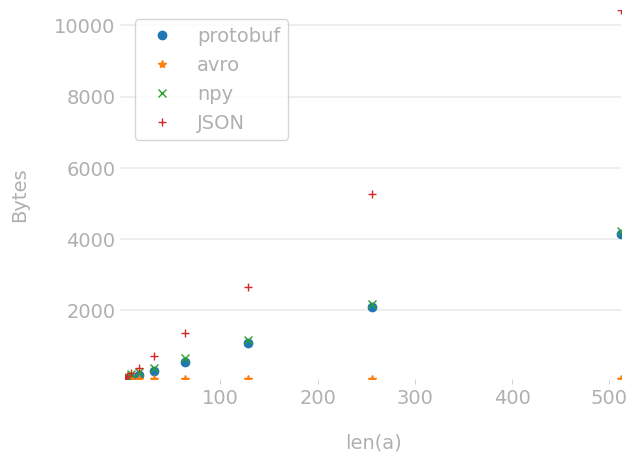

In [7]:
sizes = list(2**i for i in range(1, 10))
plt.plot(sizes, [protobuf_size(np.random.rand(size)) for size in sizes], "o", label="protobuf")
plt.plot(sizes, [avro_size(np.random.rand(size)) for size in sizes], "*", label="avro")
plt.plot(sizes, [npy_size(np.random.rand(size)) for size in sizes], "x", label="npy")
plt.plot(sizes, [json_size(np.random.rand(size)) for size in sizes], "+", label="JSON")
plt.ylabel("Bytes")
plt.xlabel("len(a)")
plt.legend()
plt.show()